# NLM3 — Task 2: Sentiment Analysis Using Neural Networks

## Part I: Research Question

### A.  Describe the purpose of this data analysis by doing the following:



1. Can we automatically determine the sentiment (either positive, or negative) of a future reviews left online, so that they can automatically be directed to the appropriate departments for follow up when necesarry.

2. The goal is to build a neural network, trained on previous reviews the company has recieved across 2 different websites (amazon and yelp). This Neural Network will have the ability to determine the sentiment of a future review left on on of these sites.

3. A Recurrent Neural Network or RNN can be used to determine the binary sentiment of a text string after being trained on labeled data. Since we already have labeled data, this is a good option for what we are needing to do.

## Part II: Data Preparation

In [224]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import re
import math

In [225]:
amazon_df = pd.read_csv('amazon_cells_labelled.txt', delimiter='\t', header=None)
yelp_df = pd.read_csv('yelp_labelled.txt', delimiter='\t', header=None)


df = pd.concat([amazon_df, yelp_df], ignore_index=True)
df.columns = ['review', 'score']


with pd.option_context('display.max_rows', 5, 'display.max_columns', None):
    display(df)

,review,score
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
...,...,...
1998,"The whole experience was underwhelming, and I ...",0
1999,"Then, as if I hadn't wasted enough of my life ...",0


### B. Summarize the data cleaning process by doing the following:



> 1. Perform exploratory data analysis on the chosen data set, and include an explanation of each of the following elements:

- presence of unusual characters (e.g., emojis, non-English characters)

Letters, numbers, and punctiation are all expected characters in reviews posted online. The neural network should be able to handle these typical english characters well. But often punctuation marks do not contribute significant value to the sentiment of the phrase, so to simplify the analysis and better facilitate proper results, we are going to remove them. Additionally, any non english characters or non literary characters like emojis would clash with the otherwise english alphabet the neural network will be using. So we should identify these other characters and remove them too. Ultimately this means only letters and numbers will remain in our text set. 

In [226]:
other_characters = set()
for review in df['review']:
    other_characters.update(re.findall(r'[^a-zA-Z0-9\s]', review))
print(''.join(list(other_characters)))

# df['review'] = df['review'].apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]+', '', x))

-%$é"ê[]:+(,/';*.&#?)!


- vocabulary size

Using the tf tokenizer we can split up our text set into a vocabulary. We are removing all of the non english characters that our previous step reported having found, we are lowercasing everything for standardization, we are splitting on the space character, and we are replacing the unknown characters (mostly numbers) with the <OOV> symbol.

In [227]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    filters='-%$é"ê[]:+(,/\';*.&#?)!\t\n',
    lower=True,
    split=' ',
    oov_token='<OOV>',
)
tokenizer.fit_on_texts(df['review'])
word_count = tokenizer.word_index

vocab_size = len(word_count) + 1

print('Size of Vocabulary:', vocab_size)
print('Sampling of Words:', list(word_count.items())[15:20])


Size of Vocabulary: 3230
Sampling of Words: [('with', 16), ('very', 17), ('t', 18), ('good', 19), ('great', 20)]



- proposed word embedding length

There are a number of different ways to determine the embedding length, and really it should be optimized foir to find the best embedding length for your given vector space and vocabulary. Some sources suggest simply using 100 dimensions. Others say to take the 4th square of your vocabulary size. We can try with both. The fourth square of my vocabulary size (rounded up) is 8.

In [228]:
embedding_length = int(np.ceil(np.sqrt(np.ceil(np.sqrt(vocab_size)))))

print('Embedding Length:', embedding_length)

Embedding Length: 8



- statistical justification for the chosen maximum sequence length

In order to maintain as much information as possible from the input dataset, I am going to elect to keep as much information as possible, and use padding to normalize my vector space for the shorter sentences. Which means my maximum sequence length will be 32.

In [229]:
max_sentence_length = 0
min_sentence_length = math.inf
for review in df['review']:
    if len(review.split()) > max_sentence_length:
        max_sentence_length = len(review.split())
    if len(review.split()) < min_sentence_length:
        min_sentence_length = len(review.split())
        
print('Max Sentence Length:', max_sentence_length)
print('Min Sentence Length:', min_sentence_length)

Max Sentence Length: 32
Min Sentence Length: 1


> 2.  Describe the goals of the tokenization process, including any code generated and packages that are used to normalize text during the tokenization process.

The goal of the tokenization process is to reduce the words from the text input set into numerical representations. I used the tf.keras tokenizer package to assign indexes to each unique word inside my dataset. The collection of these unique words makes up the vocabulary of my dataset. All of the code to do this can be seen above.

> 3.  Explain the padding process used to standardize the length of sequences. Include the following in your explanation:

To produce the padding matrix I used the pad_sequences function from the tf.keras library again. This utilized the already produced word indexes and the predetermined max length of the sequences to build a matrix of numbers. Where each row in the matrix represents 1 review. And each entry in that row represents 1 word from that review. For reviews shorter than the decided 32 length, 0s are used to fill in (or pad) the end of the row. An example of one of these number transformed and padded sequences can be seen below.

In [230]:
padding = tf.keras.preprocessing.sequence.pad_sequences(
    tokenizer.texts_to_sequences(df['review']),
    maxlen=max_sentence_length,
    padding='post',
    truncating='post',
)

print('Padding Shape:', padding.shape)
print('Padding Sample:', padding[0])

Padding Shape: (2000, 32)
Padding Sample: [  29   56    8   59  143   13   64    7  271    5   15   48   15    2
  150  451    3   63  114    6 1418    0    0    0    0    0    0    0
    0    0    0    0]


> 4.  Identify how many categories of sentiment will be used and an activation function for the final dense layer of the network.
   
Displayed below, the total number of sentiment outputs labeled in our dataset is 2. 0 meaning negative and 1 meaning positive. The activation function we will use is the Sigmoid function. It is an industry standard for binary outputs and works well with NLP problems as it returns a probability of labeling which is most reasonable for the likely outputs of an NLP problem.

In [231]:
outputs = df['score'].astype('int32').unique()
print('Outputs:', f'({len(outputs)})', outputs)
num_outputs = len(outputs)


Outputs: (2) [0 1]


> 5.  Explain the steps used to prepare the data for analysis, including the size of the training, validation, and test set split (based on the industry average).

The Steps used to prepare the data for training are as follows:
- Import the datasets from their respective files and read them in as pandas dataframes. 
- Validate the data by ensuring that the outputs are within the expected scope, and that the inputs are made up of only the expected characters.
- Remove any unwanted characters from the set of inputs.
- Cast the inputs all to lowercase so that cases don't mess up the tokenization process.
- Tokenize the inputs into numerical "word index" representations.
- Apply padding to the tokenized inputs so that they can all be the same shape.
- Split the Dataset into a Training set and a Testing set.

This last step is seen below, where we split the inputs and their corresponding outputs into 2 groups. A training set that is 80% of the data. And a test set that is the other 20%.

In [232]:
training_size = int(len(df) * 0.8)
training_input_padded = padding[:training_size]
training_output = df['score'][:training_size].values.reshape(-1, 1)
testing_input_padded = padding[training_size:]
testing_output = df['score'][training_size:].values.reshape(-1, 1)

> *6.  Provide a copy of the cleaned data set.*

Cleaned dataframe ready for analyisis will be included in the upload by the name of `cleaned_data.csv`

In [233]:
df['review'] = padding.tolist()
df.to_csv('cleaned_data.csv', index=False)  # Save to a CSV file

## Part III: Network Architecture

In [260]:
# Model
stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    verbose=0,
    mode='auto',
    restore_best_weights=True
)
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(vocab_size, 8),
    tf.keras.layers.LSTM(16, dropout=0.5),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])
model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    training_input_padded, 
    training_output, 
    epochs=15,
    batch_size=8,
    validation_split=0.2,
    callbacks=[stopping],
    verbose=1
)

Epoch 1/15
160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4893 - loss: 0.6936 - val_accuracy: 0.5594 - val_loss: 0.6889
Epoch 2/15
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4945 - loss: 0.6945 - val_accuracy: 0.5594 - val_loss: 0.6855
Epoch 3/15
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6558 - loss: 0.6420 - val_accuracy: 0.7125 - val_loss: 0.5574
Epoch 4/15
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7873 - loss: 0.4744 - val_accuracy: 0.7500 - val_loss: 0.5599
Epoch 5/15
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8837 - loss: 0.3077 - val_accuracy: 0.7437 - val_loss: 0.6091
Epoch 6/15
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9210 - loss: 0.2284 - val_accuracy: 0.7688 - val_loss: 0.6253
Epoch 7/15
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9418 - loss: 0.1762 - val_accuracy: 0.7656 - val_loss: 0.6885
Epoch 8/15
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9597 - loss: 0.1270 - val_accuracy: 0.

### C.  Describe the type of network used by doing the following:

#### 1. Provide the output of the model summary of the function from TensorFlow.



In [261]:
model.summary()

Model: "sequential_495"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_492 (Embedding)       │ (8, 32, 8)             │        25,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_505 (LSTM)                 │ (8, 16)                │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_493 (Dense)               │ (8, 1)                 │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 82,373 (321.77 KB)

 Trainable params: 27,457 (107.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 54,916 (214.52 KB)

#### 2. Discuss the number of layers, the type of layers, and the total number of parameters.

The RNN network that I used for this analysis consists of 3 layers.

1. The embedding layer that creates the embbedding vectors out of the tokenized text inputs that are passed to it. Its input shape is made up of the 8 reviews sent to it simultaneously because of the batching and the max review length of 32 that all other reviews reached with padding. Its output shape is the exact same, except for now each token has an aditional layer of depth to it, being expanded out by 8 dimensions from the embedding process.
2. The LSTM layer is the real meat of the RNN. This is the layer with all of the hidden nodes. Its doing all of the analysis on the embedding vectors to make predictions. LSTM stands for Long Short Term Memory. Which refers to a short term sequence memory being applied over long gaps in the sequence. Thus long-short-term memory. In this layer I have put 16 different node. Which is the cause for the result of 16 output numbers per review being passed in.
3. Finally the last layer is a dense layer, which is used to reduce the response down to a single value, the last layer uses a sigmoid activation function to condense all of the input values down into 1, the output. 

The total number of parameters is 82,373 which means that across all of the embeddings that passed through the multiple layers both explicit and hidden, 82,373 weights and biases got applied at the various nodes. 

I did decide to only use 1 hidden layer here, with the LSTM layer. Its very common for RNN networks to only have a few hidden layers, and in testing with upwards of 3 hidden layers, I didn't see any additional gains over just the single layer. So for the sake of keeping the netwrk light while also ensuring accuracy, we are just going to use 1 hidden LSTM layer. 

#### 3. Justify the choice of hyperparameters, including the following elements:

- activation functions
  - The only activation function that I left in my network was the Sigmoid activation in the output layer. This is considered across the industry as the best function for condensing to a binary value. I did try out using a relu activation function between my hidden layers, but that seemed to poory impact accuracy so it was removed. 

- number of nodes per layer
  - This is an interesting metric to play with, cause there is no "perfect" number to place here, It has to be discovered empirically. So thats how I did it. I set the model inside of a loop that ran performance checks at intervals of 2 digit jumps for the count of nodes in the hidden layer. It demonstrated decreasing accuracy as the size of the hidden layer nodes grew. Too small too was no good as I decided to dropout half of the nodes randomly each run in order to mitigate the chances of overfitting. The sweetspot was the range between 8 and 24. So I went with 16. 

- loss function
  - With a binary output really the best and only choice in loss functions is the `binary_crossentropy` function. It is the best for that use case.

- optimizer
  - Adam is the best optimizer. No one else need to defend that and I really don't need to either. It uses the best gradient decent for optimizing the direction of the network.

- stopping criteria
  - I did use a stopping criteria callback function to prevent wasted compute on epochs with likely worse performance. I used a patience window of 3. Which if anything was too big. 2 would have sufficed, but I wanted to be extra sure. 

- evaluation metric
  - For the evaluation metric we kept things simple. Just straight up Accuracy. A measure of the percentage of the inputs, that with the current weights in the network would predict the same value as their labels. For training purposes across the epochs however, this accuracy number had to be based on the validation set, and not the training set. This helps to further minimize the likely hood of overfitting. 

## Part IV: Model Evaluation

### D.  Evaluate the model training process and its relevant outcomes by doing the following:

1.  Discuss the impact of using stopping criteria to include defining the number of epochs, including a screenshot showing the final training epoch.

In [249]:
results = model.evaluate(testing_input_padded, testing_output)

print('Test Loss:', results[0])
print('Test Accuracy:', results[1])

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6910 - loss: 0.6303 
Test Loss: 0.6348483562469482
Test Accuracy: 0.7074999809265137


2.  Assess the fitness of the model and any actions taken to address overfitting.

3.  Provide visualizations of the model's training process, including a line graph of the loss and chosen evaluation metric.

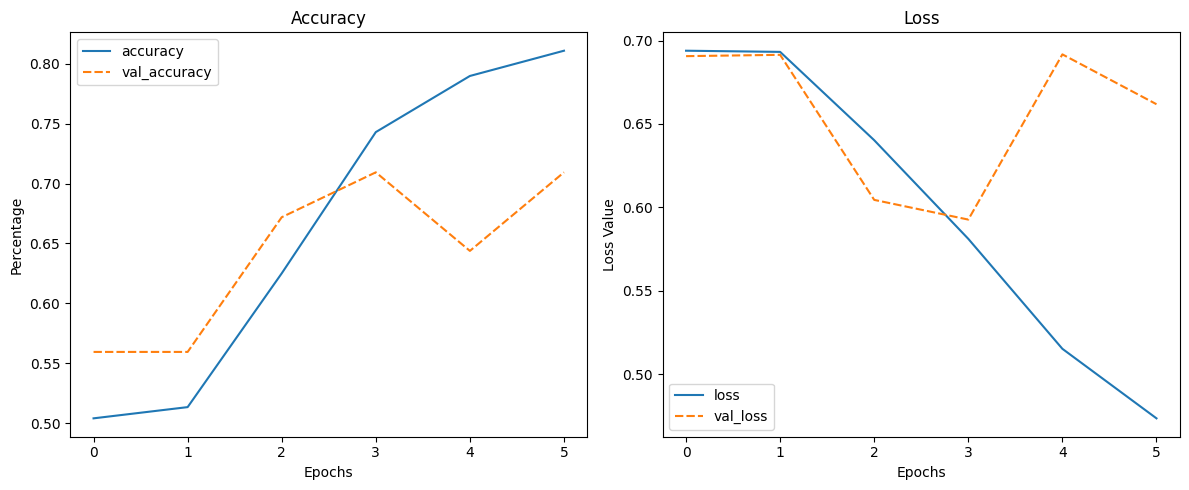

In [250]:
history_df = pd.DataFrame(history.history)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.lineplot(data=history_df[['accuracy', 'val_accuracy']], ax=axes[0])
sns.lineplot(data=history_df[['loss', 'val_loss']], ax=axes[1])
axes[0].set_title('Accuracy')
axes[1].set_title('Loss')
axes[0].set_xlabel('Epochs')
axes[1].set_xlabel('Epochs')
axes[0].set_ylabel('Percentage')
axes[1].set_ylabel('Loss Value')
plt.tight_layout()
plt.show()

4.  Discuss the predictive accuracy of the trained network using the chosen evaluation metric from part D3.

## Part V: Data Summary and Implications

### E. Provide the code you used to save the trained network within the neural network.

### F. Discuss the functionality of your neural network, including the impact of the network architecture.

### G. Recommend a course of action based on your results.

## Part VI: Reporting

### H. This Notebook
https://colab.research.google.com/drive/1SM_NGtAv50GCQj63Qiz6kKAthQ_KPgh_?usp=sharing

### I/J. Works Cited

- https://stackoverflow.com/questions/40331510/how-to-stack-multiple-lstm-in-keras
- https://d2l.ai/chapter_recurrent-neural-networks/rnn.html
- https://en.wikipedia.org/wiki/Long_short-term_memory
- https://stackoverflow.com/questions/14390224/how-to-reshape-a-pandas-series
- https://keras.io/api/callbacks/model_checkpoint/
- https://keras.io/api/models/model_training_apis/#evaluate-method
- https://keras.io/api/layers/core_layers/embedding/
- https://keras.io/api/layers/recurrent_layers/lstm/
- https://towardsdatascience.com/an-easy-tutorial-about-sentiment-analysis-with-deep-learning-and-keras-2bf52b9cba91
- https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences
- https://medium.com/@matti.kwan/finding-the-optimal-number-of-dimensions-for-word-embeddings-f19f71666723
- 